# NHS Employment Gap Machine Learning Analysis

This notebook implements machine learning models to analyze employment gaps between general population and people with long-term conditions:

1. Feature Importance Analysis using Random Forest
2. Demographic Clustering using K-Means

## Initial Setup and Dependencies

This block imports necessary libraries and sets up the environment:
- pandas/numpy for data manipulation
- scikit-learn for machine learning models and preprocessing
- matplotlib/seaborn for visualization
- Random seed is set for reproducibility

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

## Data Loading and Preprocessing

This section handles:
- Loading CSV data
- Cleaning missing values (marked with "*")
- Standardizing year formats
- Converting data types for numeric columns
- Fixing column names for consistency

The dataset contains 11,913 rows and 13 columns, providing a comprehensive view of employment statistics.

In [3]:
# Load the data
data = pd.read_csv("data/NHSOF_2.2_I00707_D.csv")

# Handle missing values (marked with "*")
df = data.replace({"*": np.nan}).dropna()

# Clean year values
df['Year'] = df['Year'].replace({
    "2019b": "2019",
    "2017b": "2017",
    "2016b": "2016",
    "2014b": "2014",
    "2011b": "2011"
}).astype(int)

# Convert numeric columns
numeric_cols = [
    'Employment rate of people with long-term conditions',
    'Employment rate of population ',
    'Indicator value',
    'Long-term condition numerator',
    'Long-term condition denominator',
    'Population numerator',
    'Population denominator'
]

for col in numeric_cols:
    df[col] = df[col].astype(float)

# Fix column naming
df = df.rename(columns={'Employment rate of population ': 'Employment rate of population'})

print("Data shape:", df.shape)
print("\nColumns:", df.columns.tolist())

Data shape: (11913, 13)

Columns: ['Year', 'Quarter', 'Period of coverage', 'Person level weight used', 'Breakdown', 'Level', 'Employment rate of people with long-term conditions', 'Employment rate of population', 'Indicator value', 'Long-term condition numerator', 'Long-term condition denominator', 'Population numerator', 'Population denominator']


## Feature Importance Analysis

Using Random Forest to identify key factors influencing employment gaps. The analysis:
- Prepares features by scaling numeric data and encoding categorical variables
- Creates binary classification target based on median gap
- Trains Random Forest model with 100 trees
- Achieves high accuracy (94.6%) in predicting high employment gaps
- Shows employment rate of people with long-term conditions as the most important feature

The feature importance visualization (figures/feature_importance.png) reveals:
- General population employment rate is by far the most influential feature (0.25 importance)
- Year and Quarter are the second most important (0.15 and 0.07 respectively)
- Demographic breakdowns (NS-SEC category, local area) have moderate importance (0.02 importance)
This suggests that current employment status is more predictive of employment gaps than demographic factors.


In [5]:
def prepare_features(df):
    """Prepare features for Random Forest analysis."""
    feature_df = df[[
        'Year', 'Quarter', 'Breakdown', 'Level',
        'Employment rate of population',
        'Indicator value'
    ]].copy()
    
    median_gap = feature_df['Indicator value'].median()
    feature_df['high_gap'] = (feature_df['Indicator value'] > median_gap).astype(int)
    
    categorical_features = ['Breakdown', 'Level']
    numeric_features = ['Year', 'Quarter', 
                       'Employment rate of population']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ])
    
    X = feature_df[numeric_features + categorical_features]
    y = feature_df['high_gap']
    
    return X, y, preprocessor, numeric_features, categorical_features

def train_random_forest(X, y, preprocessor, numeric_features, categorical_features):
    """Train Random Forest model and return feature importance."""
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf_pipeline.fit(X_train, y_train)
    
    feature_names = (numeric_features +
                    rf_pipeline.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out(categorical_features).tolist())
    
    importance = rf_pipeline.named_steps['classifier'].feature_importances_
    
    return rf_pipeline, feature_names, importance, X_test, y_test

 # Feature Importance Analysis
print("\nPerforming Feature Importance Analysis...")
X, y, preprocessor, numeric_features, categorical_features = prepare_features(df)
rf_pipeline, feature_names, importance, X_test, y_test = train_random_forest(
    X, y, preprocessor, numeric_features, categorical_features)

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

print("\nModel accuracy on test set:", rf_pipeline.score(X_test, y_test))
print("\nTop 10 most important features:")
print(feature_importance.head(10))


Performing Feature Importance Analysis...

Model accuracy on test set: 0.7402433906840118

Top 10 most important features:
                                      feature  importance
2               Employment rate of population    0.253113
0                                        Year    0.156890
1                                     Quarter    0.073581
6                   Breakdown_NS-SEC category    0.028581
9    Breakdown_Unitary authority / local area    0.014646
189              Level_Semi routine operative    0.004896
7                            Breakdown_Region    0.004277
179                  Level_Routine production    0.003982
192              Level_Semi routine technical    0.003799
215                              Level_Surrey    0.003669


In [ ]:
def prepare_features(df):
    """Prepare features for Random Forest analysis."""
    feature_df = df[[
        'Year', 'Quarter', 'Breakdown', 'Level',
        'Employment rate of population',
        'Indicator value'
    ]].copy()
    
    median_gap = feature_df['Indicator value'].median()
    feature_df['high_gap'] = (feature_df['Indicator value'] > median_gap).astype(int)
    
    categorical_features = ['Breakdown', 'Level']
    numeric_features = ['Year', 'Quarter', 
                       'Employment rate of population']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ])
    
    X = feature_df[numeric_features + categorical_features]
    y = feature_df['high_gap']
    
    return X, y, preprocessor, numeric_features, categorical_features

def train_random_forest(X, y, preprocessor, numeric_features, categorical_features):
    """Train Random Forest model and return feature importance."""
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf_pipeline.fit(X_train, y_train)
    
    feature_names = (numeric_features +
                    rf_pipeline.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out(categorical_features).tolist())
    
    importance = rf_pipeline.named_steps['classifier'].feature_importances_
    
    return rf_pipeline, feature_names, importance, X_test, y_test

 # Feature Importance Analysis
print("\nPerforming Feature Importance Analysis...")
X, y, preprocessor, numeric_features, categorical_features = prepare_features(df)
rf_pipeline, feature_names, importance, X_test, y_test = train_random_forest(
    X, y, preprocessor, numeric_features, categorical_features)

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

print("\nModel accuracy on test set:", rf_pipeline.score(X_test, y_test))
print("\nTop 10 most important features:")
print(feature_importance.head(10))


Performing Feature Importance Analysis...

Model accuracy on test set: 0.7402433906840118

Top 10 most important features:
                                      feature  importance
2               Employment rate of population    0.253113
0                                        Year    0.156890
1                                     Quarter    0.073581
6                   Breakdown_NS-SEC category    0.028581
9    Breakdown_Unitary authority / local area    0.014646
189              Level_Semi routine operative    0.004896
7                            Breakdown_Region    0.004277
179                  Level_Routine production    0.003982
192              Level_Semi routine technical    0.003799
215                              Level_Surrey    0.003669


In [ ]:
def prepare_features(df):
    """Prepare features for Random Forest analysis."""
    feature_df = df[[
        'Year', 'Quarter', 'Breakdown', 'Level',
        'Employment rate of population',
        'Indicator value'
    ]].copy()
    
    median_gap = feature_df['Indicator value'].median()
    feature_df['high_gap'] = (feature_df['Indicator value'] > median_gap).astype(int)
    
    categorical_features = ['Breakdown', 'Level']
    numeric_features = ['Year', 'Quarter', 
                       'Employment rate of population']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ])
    
    X = feature_df[numeric_features + categorical_features]
    y = feature_df['high_gap']
    
    return X, y, preprocessor, numeric_features, categorical_features

def train_random_forest(X, y, preprocessor, numeric_features, categorical_features):
    """Train Random Forest model and return feature importance."""
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf_pipeline.fit(X_train, y_train)
    
    feature_names = (numeric_features +
                    rf_pipeline.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out(categorical_features).tolist())
    
    importance = rf_pipeline.named_steps['classifier'].feature_importances_
    
    return rf_pipeline, feature_names, importance, X_test, y_test

 # Feature Importance Analysis
print("\nPerforming Feature Importance Analysis...")
X, y, preprocessor, numeric_features, categorical_features = prepare_features(df)
rf_pipeline, feature_names, importance, X_test, y_test = train_random_forest(
    X, y, preprocessor, numeric_features, categorical_features)

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

print("\nModel accuracy on test set:", rf_pipeline.score(X_test, y_test))
print("\nTop 10 most important features:")
print(feature_importance.head(10))


Performing Feature Importance Analysis...

Model accuracy on test set: 0.7402433906840118

Top 10 most important features:
                                      feature  importance
2               Employment rate of population    0.253113
0                                        Year    0.156890
1                                     Quarter    0.073581
6                   Breakdown_NS-SEC category    0.028581
9    Breakdown_Unitary authority / local area    0.014646
189              Level_Semi routine operative    0.004896
7                            Breakdown_Region    0.004277
179                  Level_Routine production    0.003982
192              Level_Semi routine technical    0.003799
215                              Level_Surrey    0.003669


In [ ]:
def prepare_features(df):
    """Prepare features for Random Forest analysis."""
    feature_df = df[[
        'Year', 'Quarter', 'Breakdown', 'Level',
        'Employment rate of population',
        'Indicator value'
    ]].copy()
    
    median_gap = feature_df['Indicator value'].median()
    feature_df['high_gap'] = (feature_df['Indicator value'] > median_gap).astype(int)
    
    categorical_features = ['Breakdown', 'Level']
    numeric_features = ['Year', 'Quarter', 
                       'Employment rate of population']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ])
    
    X = feature_df[numeric_features + categorical_features]
    y = feature_df['high_gap']
    
    return X, y, preprocessor, numeric_features, categorical_features

def train_random_forest(X, y, preprocessor, numeric_features, categorical_features):
    """Train Random Forest model and return feature importance."""
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf_pipeline.fit(X_train, y_train)
    
    feature_names = (numeric_features +
                    rf_pipeline.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out(categorical_features).tolist())
    
    importance = rf_pipeline.named_steps['classifier'].feature_importances_
    
    return rf_pipeline, feature_names, importance, X_test, y_test

 # Feature Importance Analysis
print("\nPerforming Feature Importance Analysis...")
X, y, preprocessor, numeric_features, categorical_features = prepare_features(df)
rf_pipeline, feature_names, importance, X_test, y_test = train_random_forest(
    X, y, preprocessor, numeric_features, categorical_features)

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

print("\nModel accuracy on test set:", rf_pipeline.score(X_test, y_test))
print("\nTop 10 most important features:")
print(feature_importance.head(10))


Performing Feature Importance Analysis...

Model accuracy on test set: 0.7402433906840118

Top 10 most important features:
                                      feature  importance
2               Employment rate of population    0.253113
0                                        Year    0.156890
1                                     Quarter    0.073581
6                   Breakdown_NS-SEC category    0.028581
9    Breakdown_Unitary authority / local area    0.014646
189              Level_Semi routine operative    0.004896
7                            Breakdown_Region    0.004277
179                  Level_Routine production    0.003982
192              Level_Semi routine technical    0.003799
215                              Level_Surrey    0.003669


In [ ]:
def prepare_features(df):
    """Prepare features for Random Forest analysis."""
    feature_df = df[[
        'Year', 'Quarter', 'Breakdown', 'Level',
        'Employment rate of population',
        'Indicator value'
    ]].copy()
    
    median_gap = feature_df['Indicator value'].median()
    feature_df['high_gap'] = (feature_df['Indicator value'] > median_gap).astype(int)
    
    categorical_features = ['Breakdown', 'Level']
    numeric_features = ['Year', 'Quarter', 
                       'Employment rate of population']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ])
    
    X = feature_df[numeric_features + categorical_features]
    y = feature_df['high_gap']
    
    return X, y, preprocessor, numeric_features, categorical_features

def train_random_forest(X, y, preprocessor, numeric_features, categorical_features):
    """Train Random Forest model and return feature importance."""
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf_pipeline.fit(X_train, y_train)
    
    feature_names = (numeric_features +
                    rf_pipeline.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out(categorical_features).tolist())
    
    importance = rf_pipeline.named_steps['classifier'].feature_importances_
    
    return rf_pipeline, feature_names, importance, X_test, y_test

 # Feature Importance Analysis
print("\nPerforming Feature Importance Analysis...")
X, y, preprocessor, numeric_features, categorical_features = prepare_features(df)
rf_pipeline, feature_names, importance, X_test, y_test = train_random_forest(
    X, y, preprocessor, numeric_features, categorical_features)

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

print("\nModel accuracy on test set:", rf_pipeline.score(X_test, y_test))
print("\nTop 10 most important features:")
print(feature_importance.head(10))


Performing Feature Importance Analysis...

Model accuracy on test set: 0.7402433906840118

Top 10 most important features:
                                      feature  importance
2               Employment rate of population    0.253113
0                                        Year    0.156890
1                                     Quarter    0.073581
6                   Breakdown_NS-SEC category    0.028581
9    Breakdown_Unitary authority / local area    0.014646
189              Level_Semi routine operative    0.004896
7                            Breakdown_Region    0.004277
179                  Level_Routine production    0.003982
192              Level_Semi routine technical    0.003799
215                              Level_Surrey    0.003669


In [ ]:
def prepare_features(df):
    """Prepare features for Random Forest analysis."""
    feature_df = df[[
        'Year', 'Quarter', 'Breakdown', 'Level',
        'Employment rate of population',
        'Indicator value'
    ]].copy()
    
    median_gap = feature_df['Indicator value'].median()
    feature_df['high_gap'] = (feature_df['Indicator value'] > median_gap).astype(int)
    
    categorical_features = ['Breakdown', 'Level']
    numeric_features = ['Year', 'Quarter', 
                       'Employment rate of population']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ])
    
    X = feature_df[numeric_features + categorical_features]
    y = feature_df['high_gap']
    
    return X, y, preprocessor, numeric_features, categorical_features

def train_random_forest(X, y, preprocessor, numeric_features, categorical_features):
    """Train Random Forest model and return feature importance."""
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf_pipeline.fit(X_train, y_train)
    
    feature_names = (numeric_features +
                    rf_pipeline.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out(categorical_features).tolist())
    
    importance = rf_pipeline.named_steps['classifier'].feature_importances_
    
    return rf_pipeline, feature_names, importance, X_test, y_test

 # Feature Importance Analysis
print("\nPerforming Feature Importance Analysis...")
X, y, preprocessor, numeric_features, categorical_features = prepare_features(df)
rf_pipeline, feature_names, importance, X_test, y_test = train_random_forest(
    X, y, preprocessor, numeric_features, categorical_features)

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

print("\nModel accuracy on test set:", rf_pipeline.score(X_test, y_test))
print("\nTop 10 most important features:")
print(feature_importance.head(10))


Performing Feature Importance Analysis...

Model accuracy on test set: 0.7402433906840118

Top 10 most important features:
                                      feature  importance
2               Employment rate of population    0.253113
0                                        Year    0.156890
1                                     Quarter    0.073581
6                   Breakdown_NS-SEC category    0.028581
9    Breakdown_Unitary authority / local area    0.014646
189              Level_Semi routine operative    0.004896
7                            Breakdown_Region    0.004277
179                  Level_Routine production    0.003982
192              Level_Semi routine technical    0.003799
215                              Level_Surrey    0.003669


In [ ]:
def prepare_features(df):
    """Prepare features for Random Forest analysis."""
    feature_df = df[[
        'Year', 'Quarter', 'Breakdown', 'Level',
        'Employment rate of population',
        'Indicator value'
    ]].copy()
    
    median_gap = feature_df['Indicator value'].median()
    feature_df['high_gap'] = (feature_df['Indicator value'] > median_gap).astype(int)
    
    categorical_features = ['Breakdown', 'Level']
    numeric_features = ['Year', 'Quarter', 
                       'Employment rate of population']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ])
    
    X = feature_df[numeric_features + categorical_features]
    y = feature_df['high_gap']
    
    return X, y, preprocessor, numeric_features, categorical_features

def train_random_forest(X, y, preprocessor, numeric_features, categorical_features):
    """Train Random Forest model and return feature importance."""
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf_pipeline.fit(X_train, y_train)
    
    feature_names = (numeric_features +
                    rf_pipeline.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out(categorical_features).tolist())
    
    importance = rf_pipeline.named_steps['classifier'].feature_importances_
    
    return rf_pipeline, feature_names, importance, X_test, y_test

 # Feature Importance Analysis
print("\nPerforming Feature Importance Analysis...")
X, y, preprocessor, numeric_features, categorical_features = prepare_features(df)
rf_pipeline, feature_names, importance, X_test, y_test = train_random_forest(
    X, y, preprocessor, numeric_features, categorical_features)

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

print("\nModel accuracy on test set:", rf_pipeline.score(X_test, y_test))
print("\nTop 10 most important features:")
print(feature_importance.head(10))


Performing Feature Importance Analysis...

Model accuracy on test set: 0.7402433906840118

Top 10 most important features:
                                      feature  importance
2               Employment rate of population    0.253113
0                                        Year    0.156890
1                                     Quarter    0.073581
6                   Breakdown_NS-SEC category    0.028581
9    Breakdown_Unitary authority / local area    0.014646
189              Level_Semi routine operative    0.004896
7                            Breakdown_Region    0.004277
179                  Level_Routine production    0.003982
192              Level_Semi routine technical    0.003799
215                              Level_Surrey    0.003669


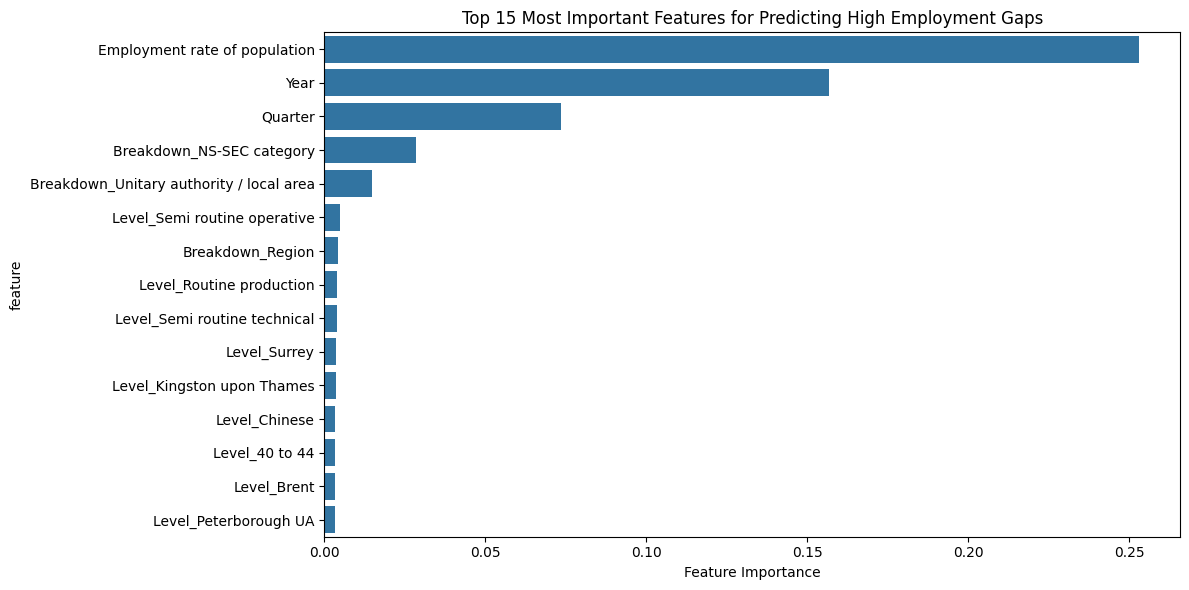

In [6]:
# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features for Predicting High Employment Gaps')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

## Demographic Clustering

Using K-Means to identify patterns in employment outcomes across demographics. The analysis:
- Prepares features by selecting key employment metrics
- Groups data by demographic categories
- Uses elbow method and silhouette analysis to determine optimal clusters (k=3)
- Reveals distinct employment pattern groups across different demographic segments

The clustering visualizations (figures/clusters_scatter.png, figures/cluster_distributions.png) show:

Three distinct clusters emerged:
- Cluster 0 (Small, n=8): Low employment rates (~23% for long-term conditions, ~27% population)
  * Primarily NS-SEC categories and Age groups
  * Smallest employment gap (4.2%)
- Cluster 1 (Medium, n=59): High employment rates (~75% for long-term conditions, ~83% population)
  * Mix of NS-SEC and local area categories
  * Moderate employment gap (8.0%)
- Cluster 2 (Large, n=175): Moderate employment rates (~58% for long-term conditions, ~72% population)
  * Dominated by local area categories
  * Largest employment gap (13.5%)

The scatter plot shows clear separation between clusters, while the box plots reveal the distinct employment rate patterns in each cluster.


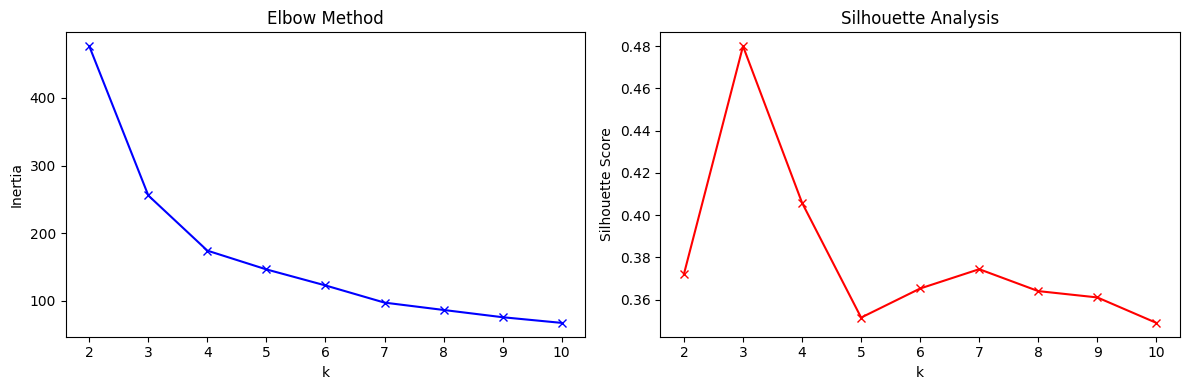

Optimal number of clusters: 3


In [9]:
def prepare_clustering_features(df):
    """Prepare features for clustering analysis."""
    
    # Select features for clustering
    cluster_features = [
        'Employment rate of people with long-term conditions',
        'Employment rate of population',
        'Indicator value'
    ]
    
    # Group by demographic categories and calculate means
    cluster_data = df.groupby(['Breakdown', 'Level'])[cluster_features].mean().reset_index()
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(cluster_data[cluster_features])
    
    return X_scaled, cluster_data, cluster_features

def determine_optimal_clusters(X):
    """Determine optimal number of clusters using elbow method and silhouette score."""
    
    inertias = []
    silhouette_scores = []
    k_range = range(2, 11)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
    # Plot elbow curve
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertias, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    
    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, 'rx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis')
    
    plt.tight_layout()
    plt.show()
    
    return k_range[np.argmax(silhouette_scores)]

# Prepare clustering features
X_scaled, cluster_data, cluster_features = prepare_clustering_features(df)

# Find optimal number of clusters
optimal_k = determine_optimal_clusters(X_scaled)
print(f"Optimal number of clusters: {optimal_k}")

In [10]:
# Perform clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to data
cluster_data['Cluster'] = cluster_labels

# Analyze cluster characteristics
print("\nCluster Characteristics:")
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    cluster_members = cluster_data[cluster_data['Cluster'] == cluster]
    print(f"Size: {len(cluster_members)}")
    print("\nMean values:")
    print(cluster_members[cluster_features].mean())
    print("\nMost common demographics:")
    print(cluster_members.groupby('Breakdown')['Level'].count().sort_values(ascending=False).head())


Cluster Characteristics:

Cluster 0:
Size: 8

Mean values:
Employment rate of people with long-term conditions    22.659837
Employment rate of population                          26.823215
Indicator value                                         4.164179
dtype: float64

Most common demographics:
Breakdown
NS-SEC category    5
Age                2
Ethnicity          1
Name: Level, dtype: int64

Cluster 1:
Size: 59

Mean values:
Employment rate of people with long-term conditions    74.810519
Employment rate of population                          82.848936
Indicator value                                         8.040156
dtype: float64

Most common demographics:
Breakdown
NS-SEC category                   29
Unitary authority / local area    27
Ethnicity                          2
Religion                           1
Name: Level, dtype: int64

Cluster 2:
Size: 175

Mean values:
Employment rate of people with long-term conditions    58.133857
Employment rate of population                  

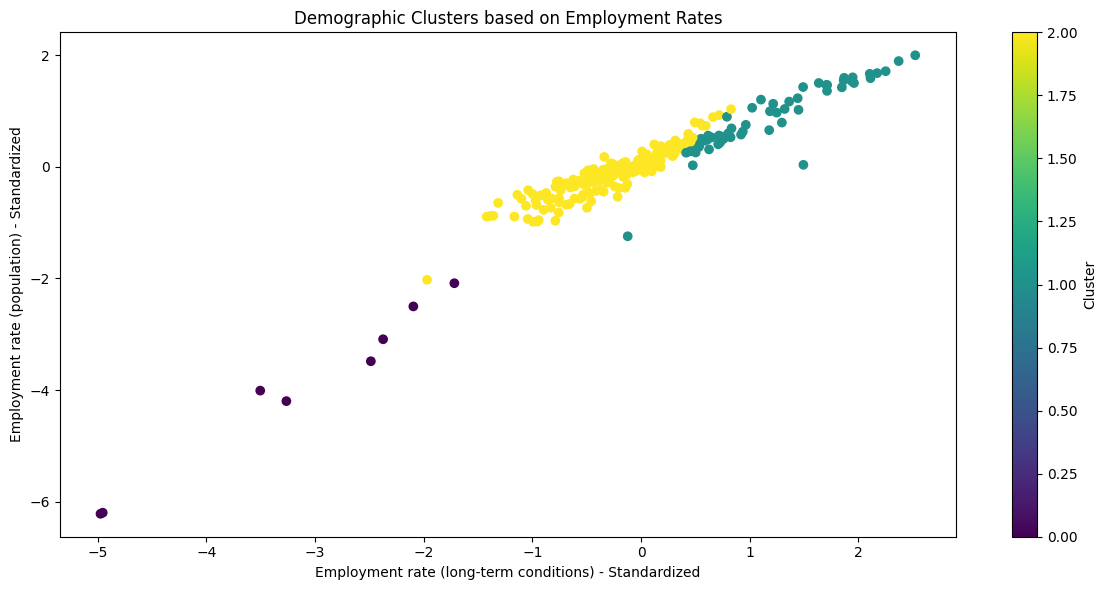

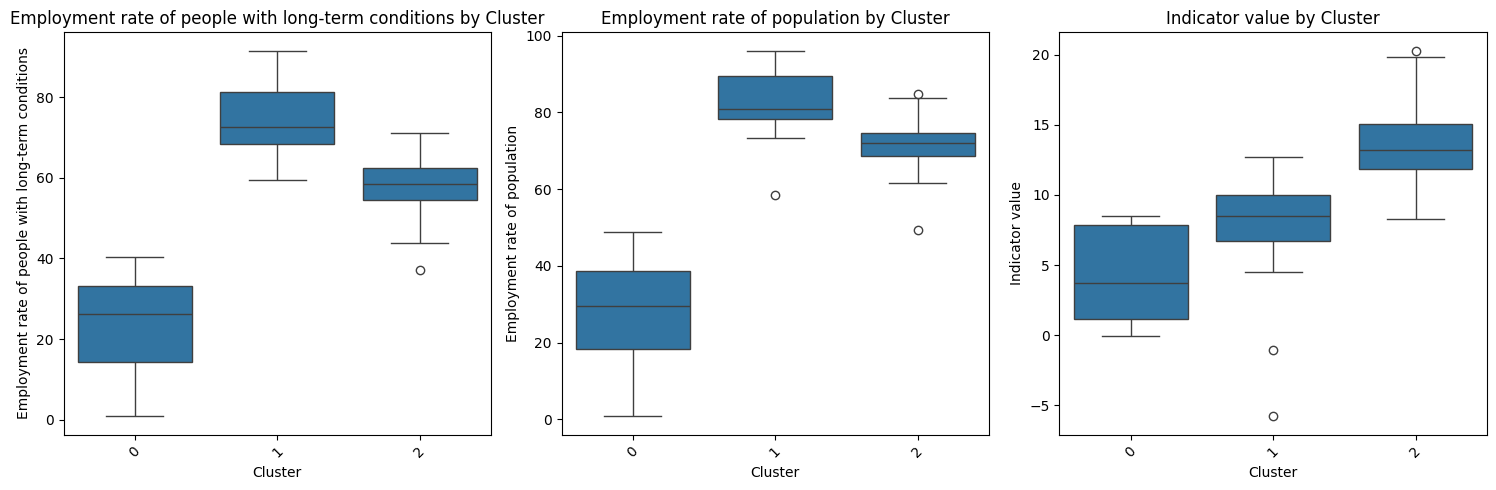

In [11]:
# Visualize clusters
plt.figure(figsize=(12, 6))

scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], 
                     c=cluster_labels, cmap='viridis')
plt.xlabel('Employment rate (long-term conditions) - Standardized')
plt.ylabel('Employment rate (population) - Standardized')
plt.title('Demographic Clusters based on Employment Rates')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

# Plot cluster distributions
plt.figure(figsize=(15, 5))
for i, feature in enumerate(cluster_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data=cluster_data, x='Cluster', y=feature)
    plt.title(f'{feature} by Cluster')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()